**Spam EMail Detection**

In [ ]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
import string
from string import punctuation
import re
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
 #Load the data set
df = pd.read_csv('/content/spam_ham_dataset.csv')
df.head(2)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0


In [ ]:
# Drop not required columns
df.drop(columns = ['Unnamed: 0','label_num'], inplace = True)
df.head(2)

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."


In [ ]:
# Check for nulls and drop duplicates if any
print(f"Total record count before dropping duplicates", {len(df)})
print(f"Null values\n",df.isnull().sum())
df = df.drop_duplicates(keep = 'first')
print(f"Total record count after dropping duplicates", {len(df)})

Total record count before dropping duplicates {5171}
Null values
 label    0
text     0
dtype: int64
Total record count after dropping duplicates {4993}


**Exploratory Data Analysis (EDA)**

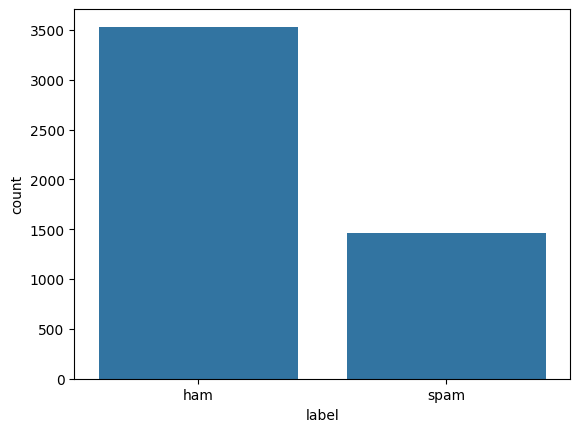

In [ ]:
sns.countplot(x='label', data=df)
plt.show()

Clearly we can see that ham count is more than spam. We can downsample the majority class but we may loose some data. It is better to upsample the minority class using SMOTE. Important thing to remember before applying the SMOTE, first split the data into train and test and apply SMOTE on train data, doing this model does not see the test data.


**Data Preprocessing**

In [ ]:
#Convert text to lower case
df['text'] = df['text'].str.lower()

#Replace the subject with blank
df['text'] = df['text'].str.replace('subject:', '')

#Convert the text into tokens
df['text'] = df['text'].apply(word_tokenize)

#Import stop words list to remove from text
stopwords_list= set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda y : [word for word in y if word not in stopwords_list and word not in string.punctuation])

#Remove special characters
df['text'] = df['text'].apply(lambda y : [re.sub(r'[^a-zA-Z0-9\s]','', word) for word in y])

#Stem the words
stemmer = PorterStemmer()
df['text'] = df['text'].apply(lambda y : [stemmer.stem(word) for word in y])

#Convert the tokens to string
df['text'] = df['text'].apply(lambda y : ' '.join(y))
df.head(2)

,label,text
0,ham,enron methanol meter 988291 follow note gave m...
1,ham,hpl nom januari 9 2001 see attach file hplnol ...


**Visualize words**

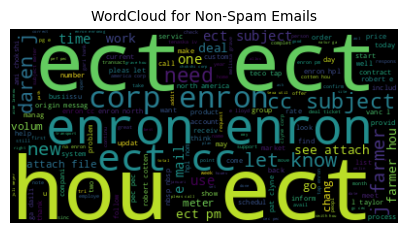

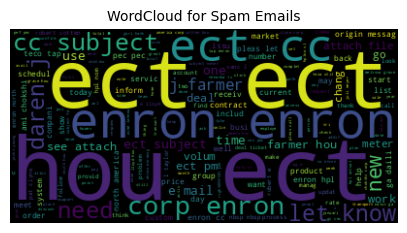

In [ ]:
def plot_word_cloud(data, lable):
    data = ' '.join(df['text'])
    wc = WordCloud(background_color='black').generate(data)
    plt.figure(figsize=(5,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {lable} Emails', fontsize=10)
    plt.axis('off')
    plt.show()

plot_word_cloud(df[df['label'] == 'ham'], 'Non-Spam')
plot_word_cloud(df[df['label'] == 'spam'], 'Spam')

**Feature Extraction**

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])

#Encode the target variable
encoder = LabelEncoder()
y = encoder.fit_transform(df['label'])

#Verify how target lable is encoded
for idx, label in enumerate(encoder.classes_):
    print(f"{label} → {idx}")

#split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

#Handle imbalance dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

#Define models to evaluate
models = {

          "Random Forest" : RandomForestClassifier(),
          "SVM" : SVC(),
          "KNN" : KNeighborsClassifier(),
          "XGBoost" : XGBClassifier(eval_metric = 'logloss'),
          "Logistic Regression" : LogisticRegression(max_iter = 1000)
          }

#Train model and find accuracy for each model
for name,model in models.items():
  print(f"********{name}:***********")
  model.fit(X_train_bal,y_train_bal)
  y_pred = model.predict(X_test)

  acc = accuracy_score(y_test,y_pred)
  pre = precision_score(y_test, y_pred)
  rec = recall_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)

  print(f"Accuracy : ", {acc})
  print(f"Precision : ", {pre})
  print(f"Recall : ", {rec})
  print(f"F1 Score : ", {f1})

ham → 0
spam → 1
********Random Forest:***********
Accuracy :  {0.96996996996997}
Precision :  {0.9100346020761245}
Recall :  {0.9850187265917603}
F1 Score :  {0.9460431654676259}
********SVM:***********
Accuracy :  {0.978978978978979}
Precision :  {0.9361702127659575}
Recall :  {0.9887640449438202}
F1 Score :  {0.9617486338797814}
********KNN:***********
Accuracy :  {0.5165165165165165}
Precision :  {0.356}
Recall :  {1.0}
F1 Score :  {0.5250737463126843}
********XGBoost:***********
Accuracy :  {0.9619619619619619}
Precision :  {0.8934707903780069}
Recall :  {0.9737827715355806}
F1 Score :  {0.931899641577061}
********Logistic Regression:***********
Accuracy :  {0.9579579579579579}
Precision :  {0.8664495114006515}
Recall :  {0.9962546816479401}
F1 Score :  {0.926829268292683}


Observed that accuracy score is more, Imagine a data set with 95% ham and 5% spam, if a model predicts everything as ham, accuracy = 95%, but spam detection is 0% - Useless. In such scenarios recall and F1 score will give the best metrics if you are more about catching spam.

**Predict on New data**

In [ ]:
# Predict using logistic regression
text = "Congratulations! You’ve been selected in our lucky draw. Claim your prize by clicking the link below. Claim Reward Offer expires in 24 hours!"

text_vector = vectorizer.transform([text])

text_vector_dence = text_vector.toarray()

prediction = model.predict(text_vector_dence)

# Print the prediction
if prediction[0] == 1:
    print("The email is predicted as spam.")
else:
    print("The email is predicted as ham.")

The email is predicted as spam.


In [ ]:
import pickle

with open("spam_detection.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

with open("vectorizer.pkl", "wb") as vector_file:
    pickle.dump(vectorizer, vector_file)